### MEV detection
In order to detect MEV 3 different methods are going to be used.


In [1]:
MERGE_BLOCK = 15537394

#### Gas price ordering (Pre+Post merge)
Check if the gas price in the transactions follows a descending order. Any deviation from it may indicate transactions added after the block was created.

In [2]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=4, processes=True, memory_limit="20GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51074,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 37.25 GiB
Comm: tcp://127.0.0.1:51206,Total threads: 4
Dashboard: http://127.0.0.1:51209/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:51085,


In [3]:
import pandas as pd

block_w_payload = pd.read_csv("block_with_payload.csv").drop_duplicates("block_number")
block_w_payload["timestamp"] = pd.to_datetime(block_w_payload["@timestamp"])

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_21774/2018918296.py:3: DtypeWarning: Columns (2,13,28,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  block_w_payload = pd.read_csv('block_with_payload.csv').drop_duplicates('block_number')


In [4]:
block_w_payload = block_w_payload.sort_values("block_number")

In [5]:
import dask.dataframe as dd

tx_data = dd.read_csv(
    "./transaction_data/tx_data*.csv",
    dtype={"gas_price": float, "block_number": float, "transaction_index": float},
    assume_missing=True,
)[["gas_price", "block_number", "transaction_index", "type"]]

In [6]:
tx_data

,gas_price,block_number,transaction_index,type
npartitions=1311,,,,
,float64,float64,float64,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [7]:
def check_gas_price_ordering(data):
    data = data.sort_values(by="transaction_index")
    if (
        data.gas_price.reset_index(drop=True)
        == data.gas_price.sort_values(ascending=False).reset_index(drop=True)
    ).all():
        # Gas price follows same ordering as transaction_index -> no MEV
        return False
    else:
        return True

In [8]:
# Group by block and check gas_price ordering
gas_price_mev = (
    tx_data.groupby("block_number").apply(check_gas_price_ordering).compute()
)

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_21774/1624916855.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  gas_price_mev = tx_data.groupby('block_number').apply(check_gas_price_ordering).compute()
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype optio

In [9]:
gas_price_mev = gas_price_mev.reset_index().rename(columns={0: "mev_gas_ordering"})

In [10]:
gas_price_mev = block_w_payload.merge(gas_price_mev, on="block_number", how="left")

#### Last transaction (Post merge)
A last transaction from the proposer/miner to another address may indicate MEV rewards being transferred from the builder to the proposer.

In [11]:
transaction_last = pd.read_csv("transaction_last.csv")

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_21774/2269292136.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction_last = pd.read_csv('transaction_last.csv')


In [12]:
transaction_last = transaction_last[transaction_last.block_number > MERGE_BLOCK]

In [13]:
# Merge block_w_payload and transaction_last on block_number
block_w_payload_w_tx_last = pd.merge(
    block_w_payload, transaction_last, on="block_number", how="left"
)

In [14]:
# MEV tx logic
block_w_payload_w_tx_last["mev_last_tx"] = (
    block_w_payload_w_tx_last["miner"] == block_w_payload_w_tx_last["from"]
)

#### Relay API (Post merge)
Relay APIs return blocks submitted to validators.

In [15]:
relay_data = pd.read_csv("relay_data.csv")
relay_data = relay_data.rename(columns={"block_height": "slot"})

In [16]:
# MEV from relay api
relay_data["mev_relay_api"] = True
block_w_payload_w_relay = pd.merge(block_w_payload, relay_data, on="slot", how="left")
block_w_payload_w_relay["mev_relay_api"] = block_w_payload_w_relay[
    "mev_relay_api"
].fillna(False)

### Charting

##### MEV ratio

In [17]:
def mev_ratio(data, col):
    return data[col].sum() / data[col].count()

In [18]:
gas_ratio = (
    gas_price_mev[["timestamp", "mev_gas_ordering"]]
    .set_index("timestamp")
    .resample("H")
    .apply(mev_ratio, "mev_gas_ordering")
)
gas_trend = (
    gas_ratio.rolling("3D")
    .mean()
    .resample("D")
    .first()
    .reset_index(drop=False)
    .rename(columns={0: "mev_trend"})
)
gas_ratio = gas_ratio.reset_index(drop=False).rename(columns={0: "mev_ratio"})

tx_ratio = (
    block_w_payload_w_tx_last[["timestamp", "mev_last_tx"]]
    .set_index("timestamp")
    .resample("H")
    .apply(mev_ratio, "mev_last_tx")
)
tx_trend = (
    tx_ratio.rolling("3D")
    .mean()
    .resample("D")
    .first()
    .reset_index(drop=False)
    .rename(columns={0: "mev_trend"})
)
tx_ratio = tx_ratio.reset_index(drop=False).rename(columns={0: "mev_ratio"})

relay_ratio = (
    block_w_payload_w_relay[["timestamp", "mev_relay_api"]]
    .set_index("timestamp")
    .resample("H")
    .apply(mev_ratio, "mev_relay_api")
)
relay_trend = (
    relay_ratio.rolling("3D")
    .mean()
    .resample("D")
    .first()
    .reset_index(drop=False)
    .rename(columns={0: "mev_trend"})
)
relay_ratio = relay_ratio.reset_index(drop=False).rename(columns={0: "mev_ratio"})

In [19]:
total_mev = block_w_payload_w_tx_last.merge(
    gas_price_mev.merge(block_w_payload_w_relay, on="block_number"), on="block_number"
)[
    [
        "timestamp",
        "block_number",
        "proposer_address",
        "slot",
        "mev_gas_ordering",
        "mev_last_tx",
        "mev_relay_api",
    ]
]

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_21774/461807425.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gas_limit_y', 'epoch_y', 'parent_hash_y', 'gas_used_y'} in the result is deprecated and will raise a MergeError in a future version.
  total_mev = block_w_payload_w_tx_last.merge(


In [20]:
total_mev["mev"] = (
    total_mev["mev_gas_ordering"].fillna(False)
    + total_mev["mev_last_tx"].fillna(False)
    + total_mev["mev_relay_api"].fillna(False)
)

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_21774/1364110150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mev['mev'] = total_mev['mev_gas_ordering'].fillna(False) + total_mev['mev_last_tx'].fillna(False) + total_mev['mev_relay_api'].fillna(False)


In [21]:
merge_time = block_w_payload[block_w_payload.block_number == MERGE_BLOCK][
    "timestamp"
].squeeze()

In [22]:
# Relays only make sense post merge
relay_ratio = relay_ratio[
    (relay_ratio.timestamp > merge_time) & (relay_ratio.timestamp < "2022-10-15")
]
relay_trend = relay_trend[
    (relay_trend.timestamp > merge_time) & (relay_trend.timestamp < "2022-10-15")
]

In [23]:
# Last tx as MEV is not used pre merge
tx_ratio = tx_ratio[
    (tx_ratio.timestamp > merge_time) & (tx_ratio.timestamp < "2022-10-15")
]
tx_trend = tx_trend[
    (tx_trend.timestamp > merge_time) & (tx_trend.timestamp < "2022-10-15")
]

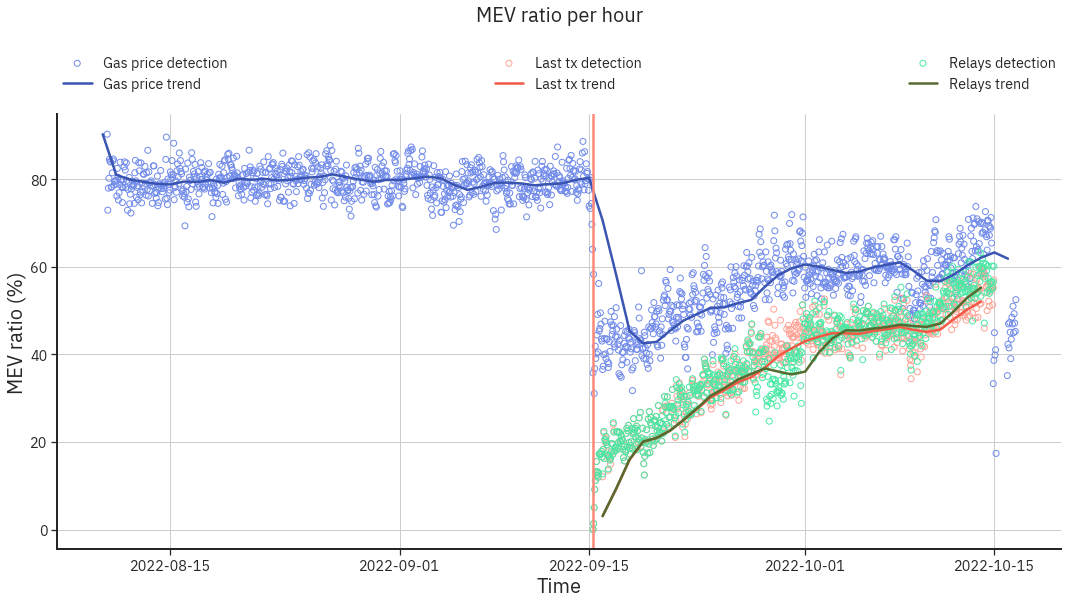

In [27]:
# Resample and get MEV per hour
# Show Merge Block
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 2,
    "axes.grid": True,
}
sns.axes_style("darkgrid", rc={"axes.linewidth": 20})
sns.set_theme(style="ticks", rc=custom_params)
params = {
    "legend.fontsize": "large",
    "font.family": "sans",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "legend.edgecolor": "white",
    "font.family": "IBM Plex Sans",
}
plt.rcParams.update(params)

fig = plt.figure(figsize=(18, 8))
plt.scatter(
    gas_ratio["timestamp"],
    gas_ratio["mev_ratio"] * 100,
    facecolors="none",
    edgecolors="#718BEA",
    label="Gas price detection",
)
plt.plot(
    gas_trend["timestamp"],
    gas_trend["mev_trend"] * 100,
    label="Gas price trend",
    color="#3A54B1",
    linewidth=2.5,
)
plt.scatter(
    tx_ratio["timestamp"],
    tx_ratio["mev_ratio"] * 100,
    facecolors="none",
    edgecolors="#FFA396",
    label="Last tx detection",
)
plt.plot(
    tx_trend["timestamp"],
    tx_trend["mev_trend"] * 100,
    label="Last tx trend",
    color="#F15B45",
    linewidth=2.5,
)
plt.scatter(
    relay_ratio["timestamp"],
    relay_ratio["mev_ratio"] * 100,
    facecolors="none",
    edgecolors="#4BE9A6",
    label="Relays detection",
)
plt.plot(
    relay_trend["timestamp"],
    relay_trend["mev_trend"] * 100,
    label="Relays trend",
    color="darkolivegreen",
    linewidth=2.5,
)
plt.axvline(merge_time, color=(255 / 255, 137 / 255, 120 / 255, 1), linewidth=2.5)
plt.legend(
    bbox_to_anchor=(0.0, 1.04, 1.0, 0.102),
    loc=3,
    ncol=3,
    mode="expand",
    borderaxespad=0.0,
)
# plt.legend()
plt.xlabel("Time", fontsize=20)
plt.ylabel("MEV ratio (%)", fontsize=20)
plt.title("MEV ratio per hour", y=1.2, fontsize=20)
plt.show()

#### Miner / Validators Distribution

In [29]:
total_miners_all_mev = pd.concat(
    [
        gas_price_mev[["timestamp", "miner", "mev_gas_ordering"]],
        block_w_payload_w_tx_last[["timestamp", "miner", "mev_last_tx"]],
        block_w_payload_w_relay[["timestamp", "miner", "mev_relay_api"]],
    ]
)

In [30]:
total_miners_all_mev["mev"] = (
    total_miners_all_mev["mev_gas_ordering"].fillna(False)
    + total_miners_all_mev["mev_last_tx"].fillna(False)
    + total_miners_all_mev["mev_relay_api"].fillna(False)
)

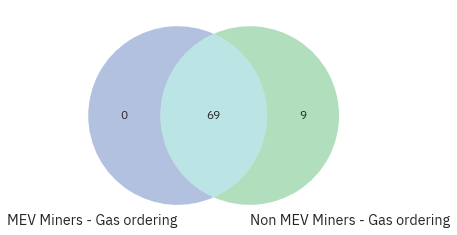

In [31]:
from matplotlib_venn import venn3, venn2_circles, venn2_unweighted, venn2

# intersection are validators / miners who have used MEV in some blocks but no alls

c = ("#3E64AF", "#3EAF5D")

# mev_miners_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev == True)]['miner'].unique())
# non_mev_miners_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev != True)]['miner'].unique())

mev_miners_gas = set(
    total_miners_all_mev[
        (total_miners_all_mev.timestamp < merge_time)
        & (total_miners_all_mev.mev_gas_ordering == True)
    ]["miner"].unique()
)
non_mev_miners_gas = set(
    total_miners_all_mev[
        (total_miners_all_mev.timestamp < merge_time)
        & (total_miners_all_mev.mev_gas_ordering != True)
    ]["miner"].unique()
)

# venn2_unweighted([mev_miners_all, non_mev_miners_all], ('MEV Miners', 'Non MEV Miners'), set_colors=c)


venn2_unweighted(
    [mev_miners_gas, non_mev_miners_gas],
    ("MEV Miners - Gas ordering", "Non MEV Miners - Gas ordering"),
    set_colors=c,
)
plt.show()

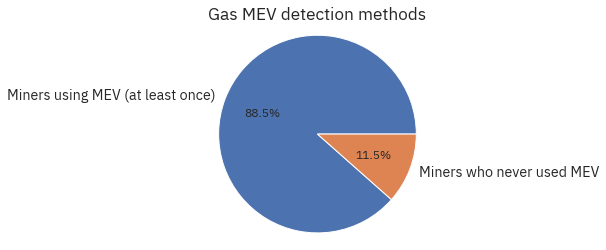

In [32]:
labels = ["Miners using MEV (at least once)", "Miners who never used MEV"]
sizes = [len(mev_miners_gas), len(non_mev_miners_gas - mev_miners_gas)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct="%1.1f%%")
ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Gas MEV detection methods")

plt.show()

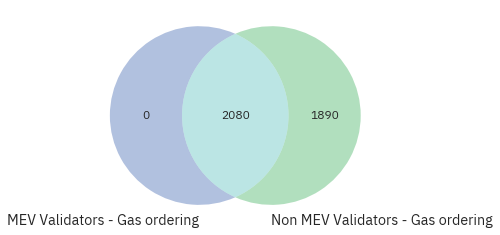

In [33]:
# mev_vals_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev == True)]['miner'].unique())
# non_mev_vals_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp > merge_time) & (total_miners_all_mev.mev != True)]['miner'].unique())

mev_vals_gas = set(
    total_miners_all_mev[
        (total_miners_all_mev.timestamp > merge_time)
        & (total_miners_all_mev.mev_gas_ordering == True)
    ]["miner"].unique()
)
non_mev_vals_gas = set(
    total_miners_all_mev[
        (total_miners_all_mev.timestamp > merge_time)
        & (total_miners_all_mev.mev_gas_ordering != True)
    ]["miner"].unique()
)

# venn2([mev_vals, non_mev_vals], ('MEV Validators', 'Non MEV Validators'), set_colors=c)
venn2_unweighted(
    [mev_vals_gas, non_mev_vals_gas],
    ("MEV Validators - Gas ordering", "Non MEV Validators - Gas ordering"),
    set_colors=c,
)

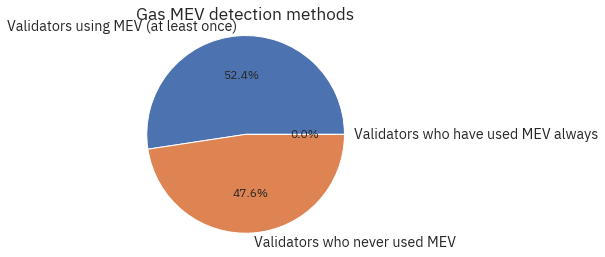

In [34]:
labels = [
    "Validators using MEV (at least once)",
    "Validators who never used MEV",
    "Validators who have used MEV always",
]
sizes = [
    len(mev_vals_gas),
    len(non_mev_vals_gas - mev_vals_gas),
    len(mev_vals_gas - non_mev_vals_gas),
]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct="%1.1f%%")
ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Gas MEV detection methods")

plt.show()

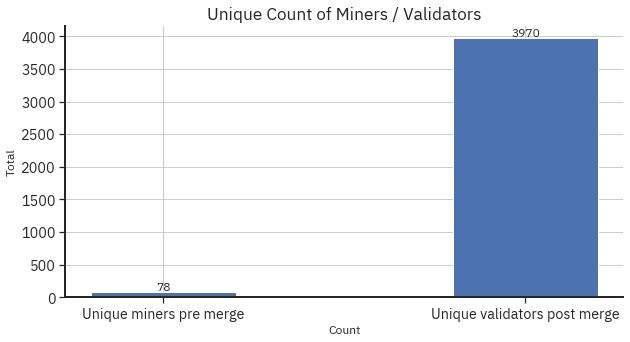

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

labels = ["Unique miners pre merge", "Unique validators post merge"]
values = [
    len(
        total_miners_all_mev[total_miners_all_mev.timestamp < merge_time][
            "miner"
        ].unique()
    ),
    len(
        total_miners_all_mev[total_miners_all_mev.timestamp > merge_time][
            "miner"
        ].unique()
    ),
]

# creating the bar plot
p1 = ax.bar(labels, values, width=0.4)

ax.bar_label(p1)

plt.xlabel("Count")
plt.ylabel("Total")
plt.title("Unique Count of Miners / Validators")
plt.show()

### Transaction count

In [36]:
tx_count_total = (
    gas_price_mev[
        ["timestamp", "transactions_count", "block_number", "mev_gas_ordering"]
    ]
    .drop_duplicates("block_number")
    .merge(
        block_w_payload_w_tx_last[["block_number", "mev_last_tx"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
    .merge(
        block_w_payload_w_relay[["block_number", "mev_relay_api"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
)

In [37]:
tx_count_total["mev"] = (
    tx_count_total["mev_gas_ordering"].fillna(False)
    + tx_count_total["mev_last_tx"].fillna(False)
    + tx_count_total["mev_relay_api"].fillna(False)
).astype(bool)

#### TPS

In [38]:
(
    (
        tx_count_total[(tx_count_total.timestamp < merge_time)]
        .set_index("timestamp")
        .resample("D")["transactions_count"]
        .sum()
        / (24 * 3600)
    ).mean(),
    (
        tx_count_total[(tx_count_total.timestamp > merge_time)]
        .set_index("timestamp")
        .resample("D")["transactions_count"]
        .sum()
        / (24 * 3600)
    ).mean(),
)

(12.112913225725729, 13.08919632523148)

In [39]:
tx_count_total["bit"] = (
    tx_count_total.sort_values("timestamp")["timestamp"].diff().dt.seconds
)

In [40]:
# Pre TPS
(
    tx_count_total[
        (tx_count_total.timestamp < merge_time) & (tx_count_total.mev == True)
    ]["transactions_count"].sum()
    / tx_count_total[
        (tx_count_total.timestamp < merge_time) & (tx_count_total.mev == True)
    ]["bit"].sum(),
    tx_count_total[
        (tx_count_total.timestamp < merge_time) & (tx_count_total.mev == False)
    ]["transactions_count"].sum()
    / tx_count_total[
        (tx_count_total.timestamp < merge_time) & (tx_count_total.mev == False)
    ]["bit"].sum(),
)

(14.431388070807305, 5.829395952558208)

In [41]:
# Post TPS
(
    tx_count_total[
        (tx_count_total.timestamp > merge_time) & (tx_count_total.mev == True)
    ]["transactions_count"].sum()
    / tx_count_total[
        (tx_count_total.timestamp > merge_time) & (tx_count_total.mev == True)
    ]["bit"].sum(),
    tx_count_total[
        (tx_count_total.timestamp > merge_time) & (tx_count_total.mev == False)
    ]["transactions_count"].sum()
    / tx_count_total[
        (tx_count_total.timestamp > merge_time) & (tx_count_total.mev == False)
    ]["bit"].sum(),
)

(16.242620750783367, 9.195369646849429)

#### Blocks with no transactions

In [42]:
(
    tx_count_total[
        (tx_count_total.timestamp < merge_time)
        & (tx_count_total.transactions_count == 0)
    ].shape[0],
    tx_count_total[
        (tx_count_total.timestamp > merge_time)
        & (tx_count_total.transactions_count == 0)
    ].shape[0],
)

(8715, 1068)

#### Rest of blocks

In [43]:
tx_count_total = tx_count_total[tx_count_total.transactions_count > 1]

In [44]:
# Max txs
(
    tx_count_total[tx_count_total.timestamp < merge_time].transactions_count.max(),
    tx_count_total[tx_count_total.timestamp > merge_time].transactions_count.max(),
)

(1418.0, 1410.0)

Text(0.5, 1.15, 'Transaction Count Pre merge')

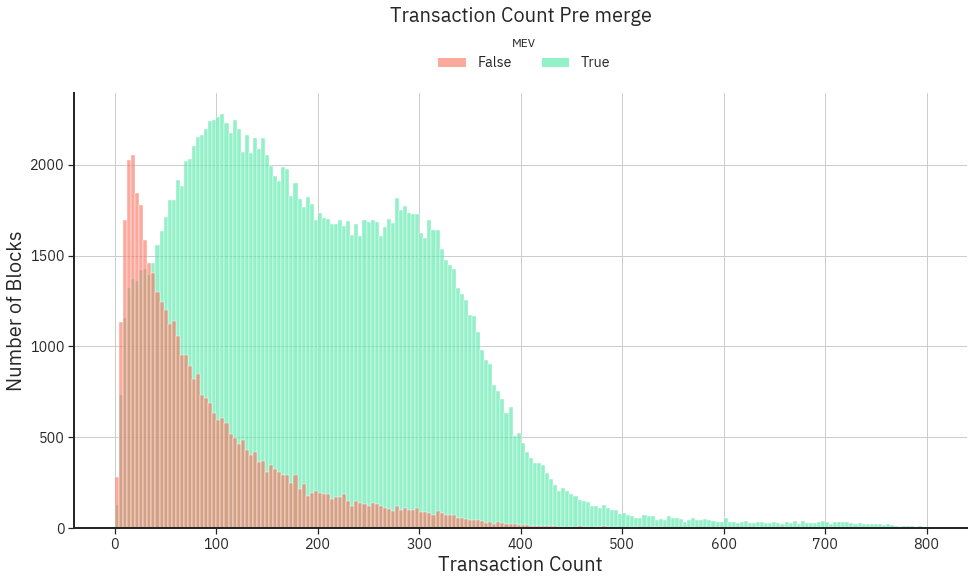

In [68]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=tx_count_total[tx_count_total.timestamp < merge_time],
    x="transactions_count",
    hue="mev",
    stat="count",
    bins=200,
    binrange=(0.1, 800),
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("Transaction Count", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Transaction Count Pre merge", fontsize=20, y=1.15)

Text(0.5, 1.05, 'Transaction Count Pre merge')

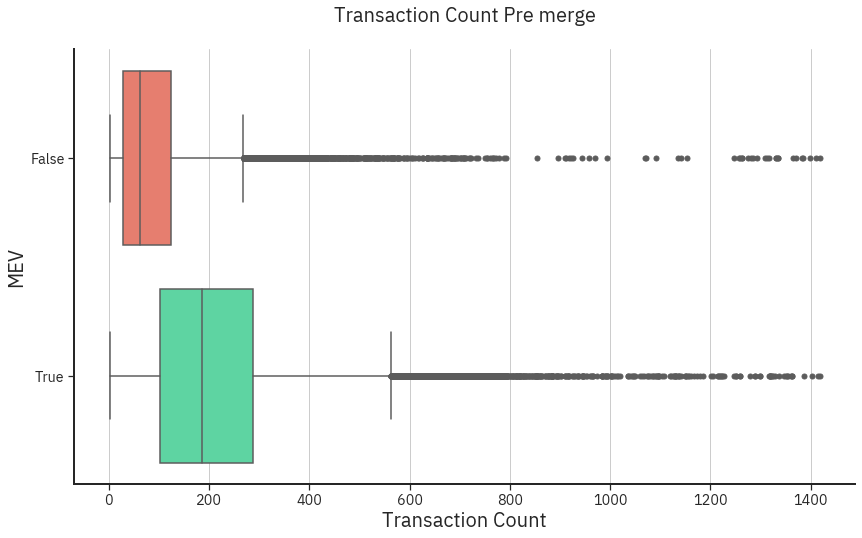

In [118]:
fig = plt.figure(figsize=(14, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 0.6),
    False: (251 / 256, 112 / 256, 92 / 256, 0.6),
}
sns.boxplot(
    data=tx_count_total[(tx_count_total.timestamp < merge_time)],
    x="transactions_count",
    y="mev",
    orient="h",
    palette=palette,
    flierprops={"marker": "o"},
)
plt.xlabel("Transaction Count", fontsize=20)
plt.ylabel("MEV", fontsize=20)
plt.title("Transaction Count Pre merge", fontsize=20, y=1.05)

Text(0.5, 1.15, 'Transaction Count Post merge')

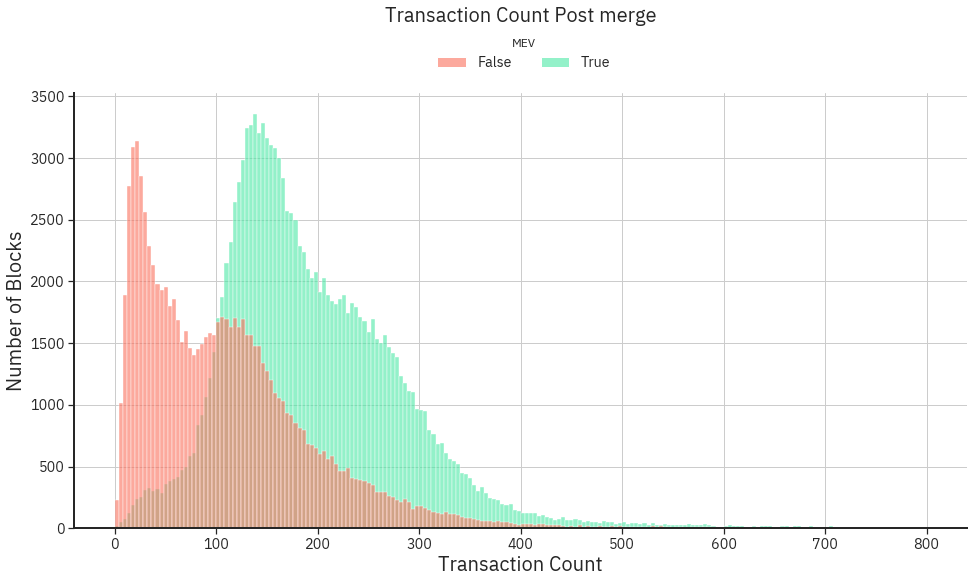

In [69]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=tx_count_total[tx_count_total.timestamp > merge_time],
    x="transactions_count",
    hue="mev",
    stat="count",
    bins=200,
    binrange=(0.1, 800),
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("Transaction Count", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Transaction Count Post merge", fontsize=20, y=1.15)

Text(0.5, 1.05, 'Transaction Count Post merge')

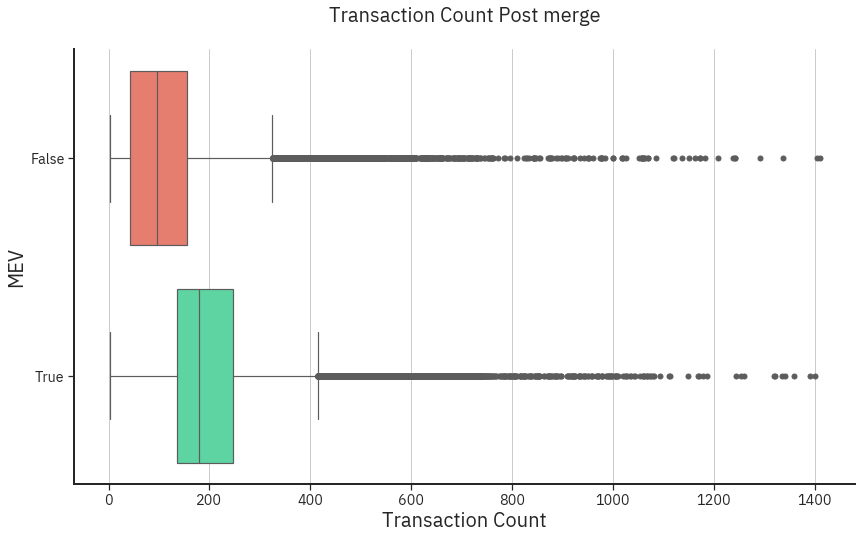

In [121]:
fig = plt.figure(figsize=(14, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 0.6),
    False: (251 / 256, 112 / 256, 92 / 256, 0.6),
}
sns.boxplot(
    data=tx_count_total[(tx_count_total.timestamp > merge_time)],
    x="transactions_count",
    y="mev",
    orient="h",
    palette=palette,
    linewidth=1.2,
    flierprops={"marker": "o"},
)
plt.xlabel("Transaction Count", fontsize=20)
plt.ylabel("MEV", fontsize=20)
plt.title("Transaction Count Post merge", fontsize=20, y=1.05)

### Gas used

In [71]:
gas_used = (
    gas_price_mev[
        [
            "timestamp",
            "transactions_count",
            "block_number",
            "gas_used",
            "mev_gas_ordering",
        ]
    ]
    .drop_duplicates("block_number")
    .merge(
        block_w_payload_w_tx_last[["block_number", "mev_last_tx"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
    .merge(
        block_w_payload_w_relay[["block_number", "mev_relay_api"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
)

In [72]:
gas_used = gas_used[~gas_used.gas_used.isna()]

In [73]:
gas_used["mev"] = (
    gas_used["mev_gas_ordering"].fillna(False)
    + gas_used["mev_last_tx"].fillna(False)
    + gas_used["mev_relay_api"].fillna(False)
)

In [74]:
gas_used = gas_used[["timestamp", "gas_used", "mev"]].drop_duplicates()

Text(0.5, 1.15, 'Gas Used Pre merge')

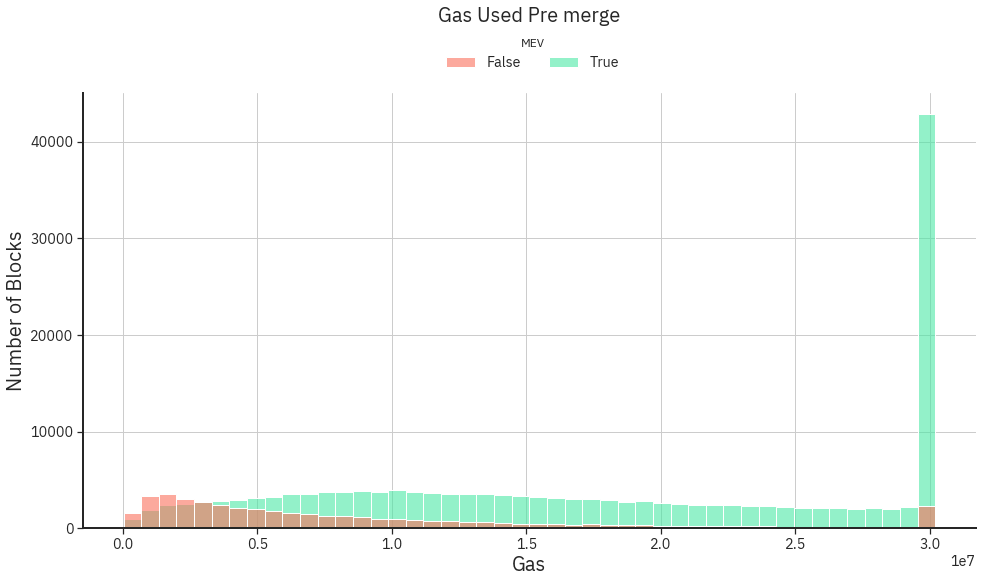

In [75]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=gas_used[(gas_used.timestamp < merge_time) & (gas_used.gas_used > 0)],
    x="gas_used",
    hue="mev",
    stat="count",
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("Gas", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Gas Used Pre merge", fontsize=20, y=1.15)

Text(0.5, 1.15, 'Gas Used Post merge')

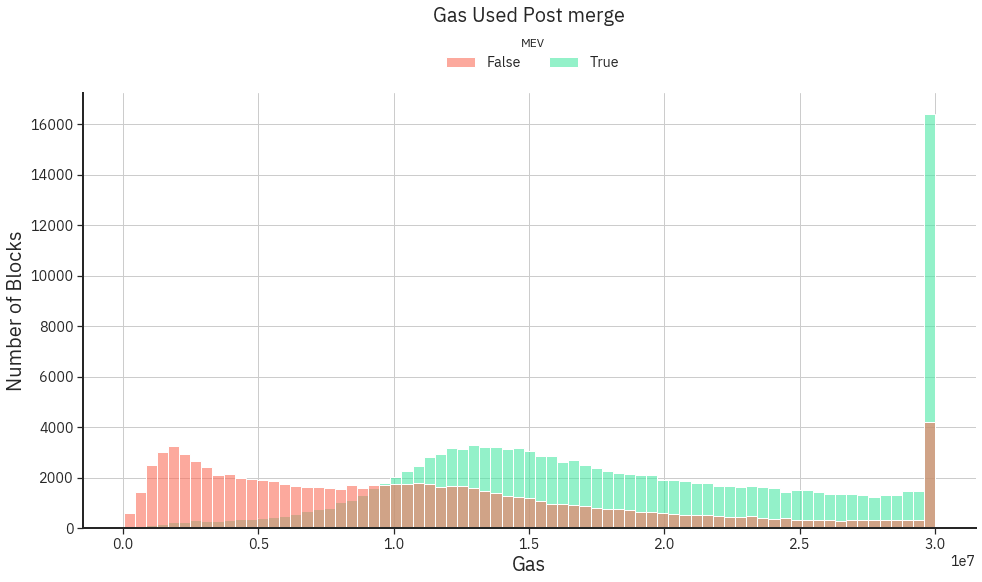

In [76]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=gas_used[(gas_used.timestamp > merge_time) & (gas_used.gas_used > 0)],
    x="gas_used",
    hue="mev",
    stat="count",
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("Gas", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Gas Used Post merge", fontsize=20, y=1.15)

#### Block Reward

In [77]:
block_reward = (
    gas_price_mev[
        [
            "timestamp",
            "transactions_count",
            "block_number",
            "block_reward",
            "mev_gas_ordering",
        ]
    ]
    .drop_duplicates("block_number")
    .merge(
        block_w_payload_w_tx_last[["block_number", "mev_last_tx"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
    .merge(
        block_w_payload_w_relay[["block_number", "mev_relay_api"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
)

In [78]:
block_reward["mev"] = (
    block_reward["mev_gas_ordering"].fillna(False)
    + block_reward["mev_last_tx"].fillna(False)
    + block_reward["mev_relay_api"].fillna(False)
)

In [79]:
block_reward["block_reward"] = block_reward["block_reward"].astype(float)

In [80]:
block_reward["block_reward"] = block_reward["block_reward"] / (10 ** (18))

In [81]:
block_reward.loc[block_reward.timestamp < merge_time, "block_reward"] = (
    block_reward[block_reward.timestamp < merge_time]["block_reward"] - 2
)

Text(0.5, 1.15, 'Block Reward Pre merge')

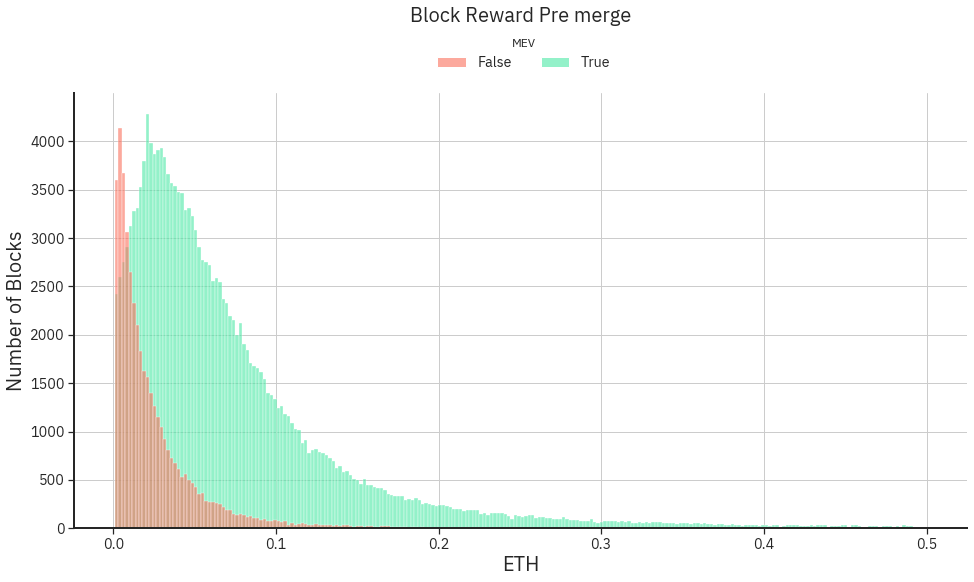

In [82]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=block_reward[block_reward.timestamp < merge_time],
    x="block_reward",
    hue="mev",
    binrange=(0.001, 0.5),
    stat="count",
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("ETH", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Block Reward Pre merge", fontsize=20, y=1.15)

Text(0.5, 1.15, 'Block Reward Post merge')

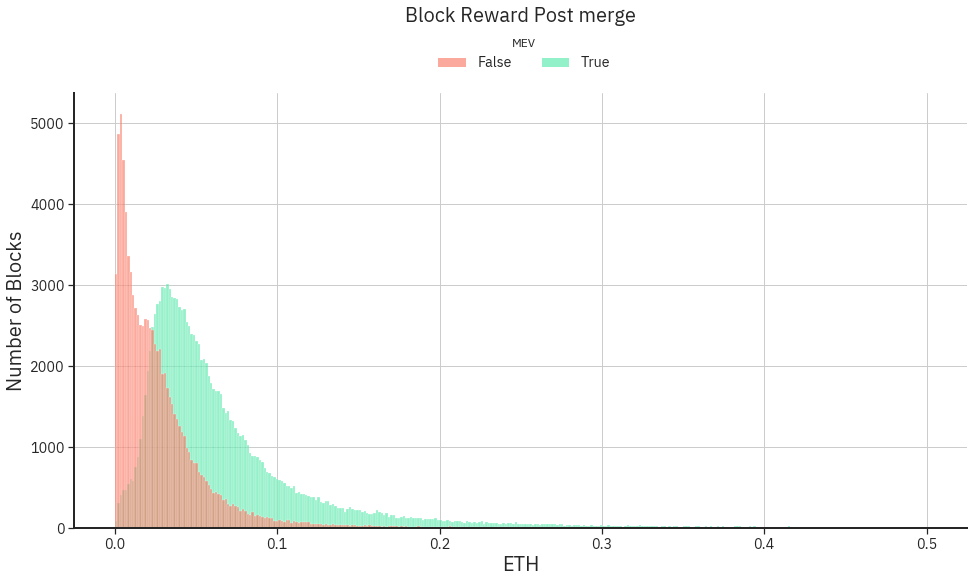

In [83]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=block_reward[block_reward.timestamp > merge_time],
    x="block_reward",
    hue="mev",
    binrange=(0, 0.5),
    stat="count",
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("ETH", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Block Reward Post merge", fontsize=20, y=1.15)

#### Transaction Fee 

In [84]:
tx_fee = (
    gas_price_mev[
        [
            "timestamp",
            "transactions_count",
            "block_number",
            "transaction_fees",
            "mev_gas_ordering",
        ]
    ]
    .drop_duplicates("block_number")
    .merge(
        block_w_payload_w_tx_last[["block_number", "mev_last_tx"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
    .merge(
        block_w_payload_w_relay[["block_number", "mev_relay_api"]].drop_duplicates(
            "block_number"
        ),
        on="block_number",
        how="outer",
    )
)

In [85]:
tx_fee["mev"] = (
    tx_fee["mev_gas_ordering"].fillna(False)
    + tx_fee["mev_last_tx"].fillna(False)
    + tx_fee["mev_relay_api"].fillna(False)
)

In [86]:
tx_fee["transaction_fees"] = tx_fee["transaction_fees"].astype(float)
tx_fee["transaction_fees"] = tx_fee["transaction_fees"] / (10 ** (18))

Text(0.5, 1.15, 'Transaction Fee Pre merge')

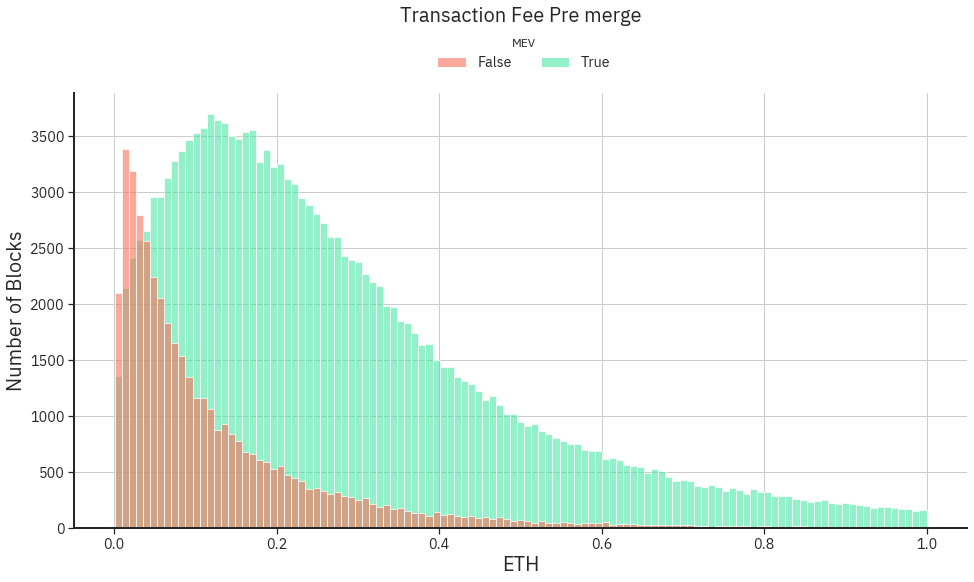

In [87]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=tx_fee[tx_fee.timestamp < merge_time],
    x="transaction_fees",
    hue="mev",
    stat="count",
    binrange=(0.001, 1),
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("ETH", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Transaction Fee Pre merge", fontsize=20, y=1.15)

Text(0.5, 1.15, 'Transaction Fee Post merge')

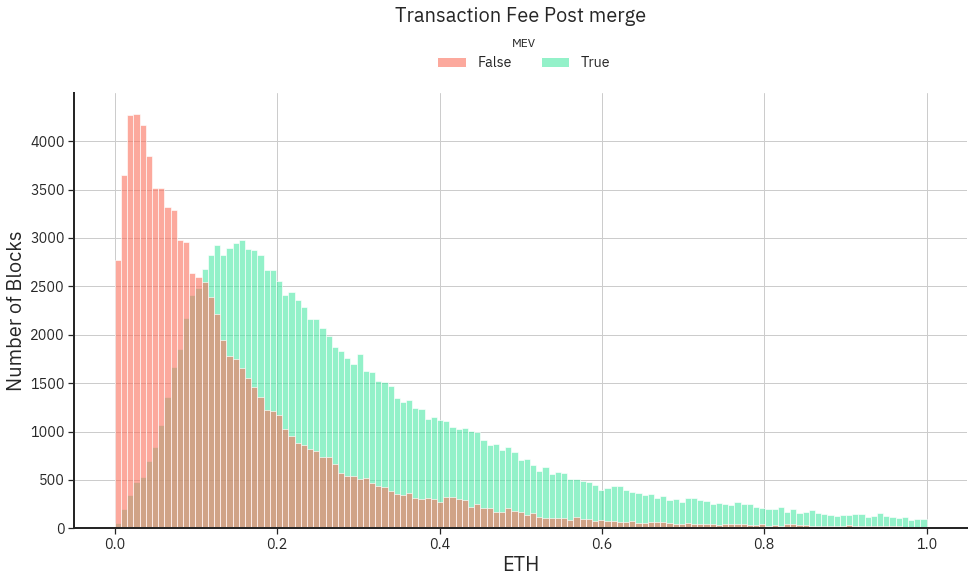

In [88]:
fig = plt.figure(figsize=(16, 8))
palette = {
    True: (75 / 256, 233 / 256, 166 / 256, 1),
    False: (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=tx_fee[tx_fee.timestamp > merge_time],
    x="transaction_fees",
    hue="mev",
    stat="count",
    binrange=(0, 1),
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("ETH", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("Transaction Fee Post merge", fontsize=20, y=1.15)

#### MEV rewards vs block rewards?

In [89]:
block_w_payload_w_tx_last.loc[
    block_w_payload_w_tx_last.mev_last_tx == True, "mev_value"
] = block_w_payload_w_tx_last.loc[
    block_w_payload_w_tx_last.mev_last_tx == True, "value"
]
block_w_payload_w_tx_last["mev_value"] = (
    block_w_payload_w_tx_last["mev_value"].fillna(0).astype(float)
)

In [90]:
block_w_payload_w_relay.loc[
    block_w_payload_w_relay.mev_relay_api == True, "mev_value"
] = block_w_payload_w_relay.loc[block_w_payload_w_relay.mev_relay_api == True, "value"]
block_w_payload_w_relay["mev_value"] = (
    block_w_payload_w_relay["mev_value"].fillna(0).astype(float)
)

In [91]:
post_mev_rewards = block_w_payload_w_tx_last.merge(
    block_w_payload_w_relay[
        ["mev_value", "block_number", "mev_relay_api", "block_reward"]
    ],
    on=["block_number", "block_reward"],
)

In [92]:
post_mev_rewards["mev"] = post_mev_rewards["mev_last_tx"].fillna(
    False
) + post_mev_rewards["mev_relay_api"].fillna(False)

In [93]:
post_mev_rewards["mev_value"] = (
    post_mev_rewards["mev_value_x"] + post_mev_rewards["mev_value_y"]
)

In [94]:
post_mev_rewards["mev_value"] = post_mev_rewards["mev_value"] / (10 ** (18))

In [95]:
post_mev_rewards = post_mev_rewards[post_mev_rewards.timestamp > merge_time]

In [96]:
post_mev_rewards["block_reward"] = post_mev_rewards["block_reward"] / (10 ** (18))

In [97]:
avg_block_reward = (
    post_mev_rewards[
        (post_mev_rewards.timestamp > merge_time) & (post_mev_rewards.block_reward > 0)
    ]
    .set_index("timestamp")["block_reward"]
    .resample("H")
    .mean()
    .reset_index()
    .rename(columns={"block_reward": "avg_block_reward"})
)

In [98]:
avg_mev_reward = (
    post_mev_rewards.set_index("timestamp")["mev_value"]
    .resample("H")
    .mean()
    .reset_index()
    .rename(columns={"mev_value": "avg_mev_reward"})
)

In [99]:
avg_mev_reward["avg_mev_reward"] = pd.concat(
    [avg_mev_reward["avg_mev_reward"], avg_block_reward["avg_block_reward"]], axis=1
).max(axis=1)

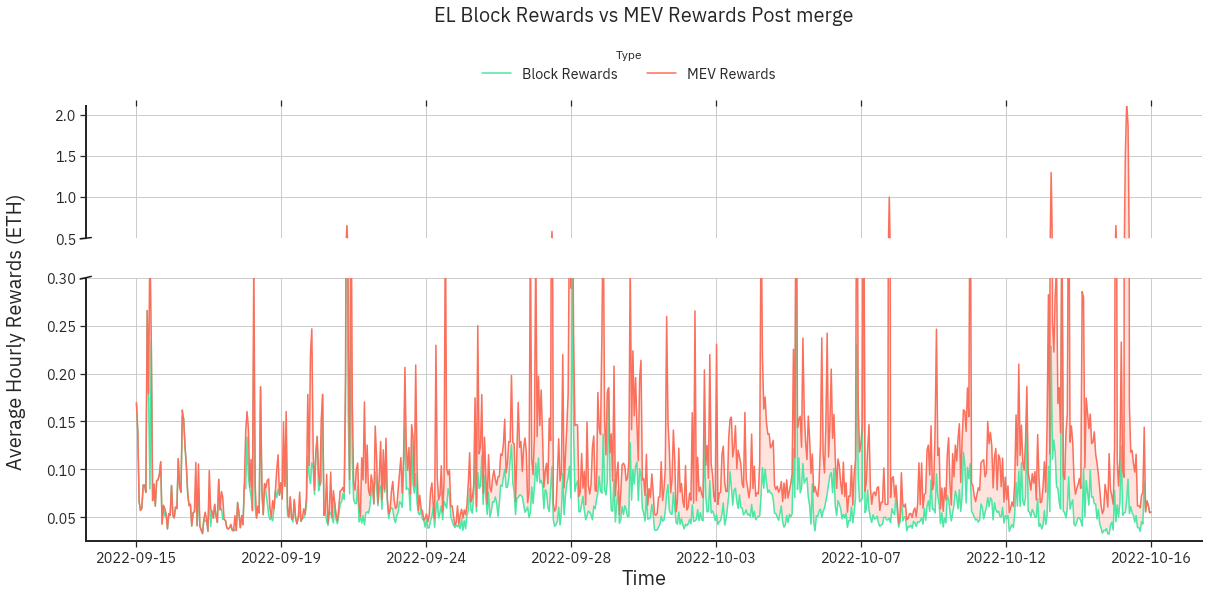

In [202]:
f, (ax, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(20, 8), gridspec_kw={"height_ratios": [1, 2]}
)
ax.plot(
    avg_block_reward["timestamp"],
    avg_block_reward["avg_block_reward"],
    label="Block Rewards",
    color=(75 / 256, 233 / 256, 166 / 256, 1),
)
ax.plot(
    avg_mev_reward.timestamp,
    avg_mev_reward.avg_mev_reward,
    label="MEV Rewards",
    color=(251 / 256, 112 / 256, 92 / 256, 1),
)

ax2.plot(
    avg_block_reward["timestamp"],
    avg_block_reward["avg_block_reward"],
    label="Block Rewards",
    color=(75 / 256, 233 / 256, 166 / 256, 1),
)
ax2.plot(
    avg_mev_reward.timestamp,
    avg_mev_reward.avg_mev_reward,
    label="MEV Rewards",
    color=(251 / 256, 112 / 256, 92 / 256, 1),
)

ax.fill_between(
    avg_block_reward["timestamp"],
    avg_mev_reward.avg_mev_reward,
    avg_block_reward["avg_block_reward"],
    color="#FFA396",
    alpha=0.3,
)
ax2.fill_between(
    avg_block_reward["timestamp"],
    avg_mev_reward.avg_mev_reward,
    avg_block_reward["avg_block_reward"],
    color="#FFA396",
    alpha=0.3,
)

ax.set_ylim(0.5, 2.1)  # outliers only
ax2.set_ylim(0.025, 0.3)  # most of the data

ax.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = 0.005

dates = pd.date_range(
    start=avg_mev_reward.timestamp.min(), end=avg_mev_reward.timestamp.max(), periods=8
)

kwargs = dict(transform=ax.transAxes, color="k", clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax.legend(
    bbox_to_anchor=(0.35, 1.15, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="Type",
)
# plt.legend()
plt.xlabel("Time", fontsize=20)
plt.xticks(dates)
ax2.set_ylabel("Average Hourly Rewards (ETH)", fontsize=20, y=0.8, labelpad=20)
ax.set_title("EL Block Rewards vs MEV Rewards Post merge", y=1.6, fontsize=20)
plt.show()

In [100]:
post_mev_rewards.loc[post_mev_rewards.mev == True, "type"] = "MEV Rewards"
post_mev_rewards.loc[post_mev_rewards.mev == False, "type"] = "Block Rewards"

In [101]:
post_mev_rewards.loc[post_mev_rewards.mev == True, "EL rewards"] = post_mev_rewards[
    "mev_value"
]
post_mev_rewards.loc[post_mev_rewards.mev == False, "EL rewards"] = post_mev_rewards[
    "block_reward"
]

Text(0.5, 1.15, 'EL Block Reward vs MEV Rewards - Post merge')

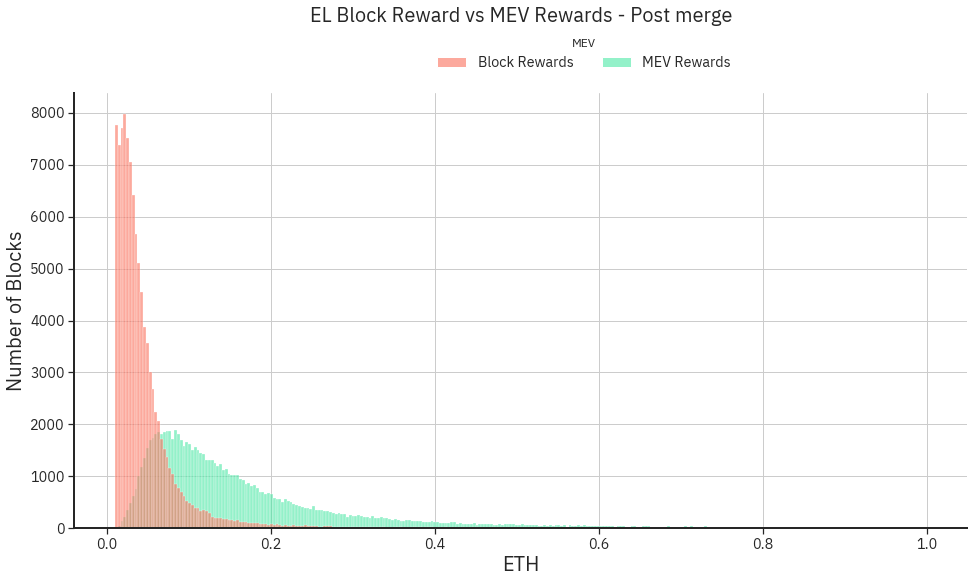

In [102]:
fig = plt.figure(figsize=(16, 8))
palette = {
    "MEV Rewards": (75 / 256, 233 / 256, 166 / 256, 1),
    "Block Rewards": (251 / 256, 112 / 256, 92 / 256, 1),
}
g = sns.histplot(
    data=post_mev_rewards,
    x="EL rewards",
    hue="type",
    binrange=(0.01, 1),
    palette=palette,
    alpha=0.6,
)
sns.move_legend(
    g,
    bbox_to_anchor=(0.4, 1.04, 1.0, 0.102),
    loc=3,
    ncol=2,
    borderaxespad=0.0,
    title="MEV",
)
plt.xlabel("ETH", fontsize=20)
plt.ylabel("Number of Blocks", fontsize=20)
plt.title("EL Block Reward vs MEV Rewards - Post merge", fontsize=20, y=1.15)

In [222]:
post_mev_rewards[post_mev_rewards.mev == True]["mev_value"].describe()

count    91147.000000
mean         0.287351
std          1.659167
min          0.008291
25%          0.079782
50%          0.130073
75%          0.222429
max        278.454792
Name: mev_value, dtype: float64

In [223]:
post_mev_rewards[post_mev_rewards.mev == False]["block_reward"].astype(float).describe()

count    133375.000000
mean          0.046814
std           0.195239
min           0.000000
25%           0.011586
50%           0.026615
75%           0.047247
max          19.176234
Name: block_reward, dtype: float64